<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
import os
import shutil

In [ ]:
Npath='/content/drive/MyDrive/Negative'
Ppath='/content/drive/MyDrive/Positive'
Nfiles=[f for f in os.listdir(Npath)]
Pfiles=[f for f in os.listdir(Ppath)]

In [ ]:
#train_data
class trainDataset(Dataset):
    def __init__(self,Nfiles,Pfiles):
      #创建一个list用来储存图片和标签信息
      imgs = []
      for i in range(60):
        imgs.append((Npath+'/'+Nfiles[i],0))
      for file in Pfiles:
        imgs.append((Ppath+'/'+file,1))
      self.imgs = imgs
	#返回数据集大小
    def __len__(self):
        return len(self.imgs)
	#打开index对应图片进行预处理后return回处理后的图片和标签
    def __getitem__(self, index):
        pic,label = self.imgs[index]
        pic = Image.open(pic).convert('RGB')
        pic = transforms.Resize([256,256])(pic)
        pic = transforms.ToTensor()(pic)
        return pic,label
#实例化对象
data = trainDataset(Nfiles,Pfiles)
#将数据集导入DataLoader，进行shuffle以及选取batch_size
data_loader = DataLoader(data,batch_size=100,shuffle=True,num_workers=0)

In [ ]:
import numpy as np
a=np.arange(10)
np.random.shuffle(a)
print(a)

[2 5 3 8 6 4 7 9 0 1]


In [ ]:
import numpy as np
#test_data
class testDataset(Dataset):
    def __init__(self,Nfiles,Pfiles):
      imgs = []
      index=np.arange(50)
      np.random.shuffle(index)
      for i in index[0:20]: #取10个0到50的随机数
        imgs.append((Npath+'/'+Nfiles[i+40],0))
      np.random.shuffle(index)
      for i in index[0:20]:
        imgs.append((Ppath+'/'+Pfiles[i],1))
      self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, index):
        pic,label = self.imgs[index]
        pic = Image.open(pic).convert('RGB')
        pic = transforms.Resize([256,256])(pic)
        pic = transforms.ToTensor()(pic)
        return pic,label
test_data = testDataset(Nfiles,Pfiles)
test_data_loader = DataLoader(test_data,batch_size=50,shuffle=True,num_workers=0)

In [ ]:
for pics,label in data_loader:
    continue

In [ ]:
for pics,label in test_data_loader:
    continue

In [ ]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import matplotlib.pyplot as plt

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #卷积层1
        self.conv1 = nn.Sequential(     #input shape (3,256,256)
            nn.Conv2d(in_channels=3,    #input height
                 out_channels=16,   #n_filter
                 kernel_size=3,    #filter size
                 stride=1,       #filter step
                 padding=1       #con2d出来的图片大小不变
                 ),           #output shape (16,128,128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   #2x2采样，output shape (16,128,128)

        )
        #卷积层2
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), #output shape (32,64,64)
                       nn.ReLU(),
                       nn.MaxPool2d(2))
        #全连接层
        self.out = nn.Linear(32*64*64,2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) #flat (batch_size, 32*64*64)
        output = self.out(x)
        return output

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release
from d2l import torch as d2l
from IPython import display
% matplotlib inline

In [ ]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
            ylim=None, xscale='linear', yscale='linear',
            fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
            figsize=(3.5, 2.5)):
    if legend is None:
      legend=[]
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x, y):
    # 向图表中添加多个数据点
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

In [ ]:
def get_accuracy(y_pred,y_target):
  n_correct=torch.eq(y_pred,y_target).sum().item()
  accuracy=n_correct/len(y_pred)
  return accuracy

In [ ]:
#args
lr=0.00005
epoch_size=100

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=131072, out_features=2, bias=True)
)


tensor([[-0.1922,  0.2745],
        [-0.1135,  0.1252],
        [-0.0838,  0.1332],
        [-0.0703,  0.0742],
        [-0.1204,  0.1623],
        [-0.0844,  0.1486],
        [-0.0123,  0.0687],
        [-0.1918,  0.2748],
        [-0.1152,  0.1607],
        [-0.0357,  0.0641],
        [-0.1117,  0.1635],
        [-0.0560,  0.0812],
        [-0.0806,  0.1272],
        [-0.0597,  0.0682],
        [-0.1010,  0.1750],
        [-0.0483,  0.0488],
        [-0.0088,  0.0119],
        [-0.2287,  0.2111],
        [-0.0267,  0.0788],
        [-0.1207,  0.1747],
        [-0.0642,  0.1192],
        [-0.0437,  0.0759],
        [-0.1719,  0.2286],
        [-0.2432,  0.3009],
        [-0.1536,  0.2037],
        [-0.0918,  0.1571],
        [-0.1430,  0.1600],
        [-0.1530,  0.1770],
        [-0.2288,  0.2110],
        [-0.0693,  0.1040],
        [-0.1375,  0.1789],
        [-0.0859,  0.1397],
        [-0.0927,  0.1475],
        [-0.0593,  0.0429],
        [-0.1023,  0.1832],
        [-0.0308,  0

RuntimeError: ignored

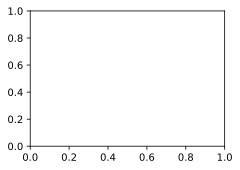

In [ ]:
#animator
animator=Animator(xlabel='epoch', xlim=[1, epoch_size], ylim=[0, 1],
            legend=['train loss','train_acc','test_acc'])
#optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)

#loss_fun
loss_func = nn.CrossEntropyLoss()

lossbuffer=[]
trainbuffer=[]
testbuffer=[]
#training loop
for epoch in range(1):
  losses=[]
  train_accs=[]
  test_accs=[]
  for i, (x, y) in enumerate(data_loader):
    batch_x = Variable(x)
    batch_y = Variable(y)
    #输入训练数据
    output = cnn(batch_x)
    _,pred=output.max(dim=1)
    #计算误差
    print(output,batch_y)
    loss = loss_func(output, batch_y)
    #计算准确度
    acc=get_accuracy(pred,batch_y)
    losses.append(loss)
    train_accs.append(acc)
    #清空上一次梯度
    optimizer.zero_grad()
    #误差反向传递
    loss.backward()
    #优化器参数更新
    optimizer.step()
  for i, (x, y) in enumerate(test_data_loader):
    batch_x = Variable(x)
    batch_y = Variable(y)
    output = cnn(batch_x)
    _,pred=output.max(dim=1)
    acc=get_accuracy(pred,batch_y)
    test_accs.append(acc)
  lossbuffer.append(sum(losses)/len(losses))
  trainbuffer.append(sum(train_accs)/len(train_accs))
  testbuffer.append(sum(test_accs)/len(test_accs))
  if epoch%2==0:
    animator.add(epoch+1,(sum(lossbuffer)/len(lossbuffer),sum(trainbuffer)/len(trainbuffer),sum(testbuffer)/len(testbuffer)))
    lossbuffer=[]
    trainbuffer=[]
    testbuffer=[]
#lossPlot

In [ ]:
torch.save(cnn,'/content/drive/MyDrive/Models/cnn.pt')

In [ ]:
cnn_from_file = CNN()
print(cnn_from_file)

In [ ]:
cnn_from_file=torch.load('/content/drive/MyDrive/Models/cnn.pt')

In [ ]:
cnn_from_file.eval()

In [ ]:
for i, (x, y) in enumerate(test_data_loader):
    batch_x = Variable(x)
    batch_y = Variable(y)
    output = cnn_from_file(batch_x)
    _,pred=output.max(dim=1)
    acc=get_accuracy(pred,batch_y)
    print(acc)
    #print(output)
    print(pred)

In [ ]:
processDataPath='/content/drive/MyDrive/Unverified'
processfiles=[f for f in os.listdir(processDataPath)]

In [ ]:
class processDataset(Dataset):
    def __init__(self,processfiles):
      img = []
      for file in processfiles:
        img.append([processDataPath+'/'+file,2,file])
      self.imgs=img
    def __len__(self):
      return len(self.imgs)
    def __getitem__(self, index):
      pic,label,name = self.imgs[index]
      pic = Image.open(pic).convert('RGB')
      pic = transforms.Resize([256,256])(pic)
      pic = transforms.ToTensor()(pic)
      return pic,label
process_data = processDataset(processfiles)
process_data_loader = DataLoader(process_data,batch_size=1,shuffle=False,num_workers=0)

In [ ]:
for pics,label in process_data_loader:
    continue

In [ ]:
res=[]
outputs=[]
for i, (x, y) in enumerate(process_data_loader):
    batch_x = Variable(x)
    batch_y = Variable(y)
    output = cnn_from_file(batch_x)
    _,pred=output.max(dim=1)
    res.append(pred.tolist()[0])
    outputs.append(output.tolist()[0])

In [ ]:
outputs=np.array(outputs)

In [ ]:
outputs

In [ ]:
def softmax(X):
  res=[]
  for i in X:
    sum=np.exp(i[0])+np.exp(i[1])
    res.append((np.exp(i[0])/sum,np.exp(i[1])/sum))
  return res
outputs=softmax(outputs)

In [ ]:
outputs=torch.Tensor(outputs)
possibility,pred=outputs.max(dim=1)

In [ ]:
import pandas as pd

In [ ]:
result=pd.DataFrame()

In [ ]:
result['Label']=pred.tolist()
result['Possibility']=possibility.tolist()

In [ ]:
list_t = [process_data.imgs[i][2] for i in range(len(process_data.imgs))]

In [ ]:
result['fileName']=list_t

In [ ]:
result.to_excel('Predict.xlsx')

In [ ]:
result